# Lab - 7

Name: Purusharth Malik

Registration No.: 2348542

### 1. Find the similarity between two documents (2 corpus or two paragraphs) using any of the two similarity measures.

- We will be using 2 random documents from the `brown` corpus available in `NLTK`.

- For word embeddings, we will use `Word2Vec`.
- For similarity measures, we will use `cosine similarity` and `jaccard similarity`.

In [18]:
from nltk.corpus import brown
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize

# Loading the two documents
document1 = brown.raw('ca01')
document2 = brown.raw('ca02')

# Tokenize documents into sentences
tokens1 = [word_tokenize(i.lower()) for i in sent_tokenize(document1)]
tokens2 = [word_tokenize(i.lower()) for i in sent_tokenize(document2)]

# Load pre-trained Word2Vec model
model = Word2Vec(sentences=tokens1 + tokens2, vector_size=50000, window=5, min_count=1)

# Get the average vector for each document
document1_vec = sum([model.wv[word] for word in tokens1[0]]) / len(tokens1[0])
document2_vec = sum([model.wv[word] for word in tokens2[0]]) / len(tokens2[0])

# Calculate cosine similarity
similarity = cosine_similarity(document1_vec.reshape(1, -1), document2_vec.reshape(1, -1))

print(f"Similarity between documents: {similarity[0][0]}")

Similarity between documents: 0.9981935024261475


In [22]:
# Tokenize documents into sets of words (avoiding duplicates)
tokens1 = set(word.lower() for sentence in sent_tokenize(document1) for word in word_tokenize(sentence))
tokens2 = set(word.lower() for sentence in sent_tokenize(document2) for word in word_tokenize(sentence))

# Intersection and Union for Jaccard Similarity
intersection = len(tokens1.intersection(tokens2))
union = len(tokens1.union(tokens2))

# Jaccard Similarity calculation
jaccard_similarity = intersection / union

print(f"Jaccard Similarity between documents: {jaccard_similarity}")

Jaccard Similarity between documents: 0.17054263565891473


### 2. Implement the Sentiment Analysis using Bayesian Classification.

- We have taken a dataset from Kaggle that provides sentiment analysis for Twitter.
- We will use TF-IDF for vectorization.

In [1]:
import numpy as np
import pandas as pd

# Loading the dataset
df = pd.read_csv('twitter_training.csv', header=None).drop([0,1], axis=1)
# Renaming the columns
df.rename({2:'labels', 3:'text'}, inplace=True, axis=1)
# Dropping empty records
df.dropna(inplace=True)
# Creating the X and y arrays
X = df['text'].values
y = df['labels'].values
# Printing the shape
print(f"Shape: {X.shape}")
# Looking at some samples
print(f"Text: {X[0]}\nLabel: {y[0]}")

Shape: (73996,)
Text: im getting on borderlands and i will murder you all ,
Label: Positive


In [2]:
# Looking at the number of unique labels
np.unique(y)

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Creating vectors using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y)

X_train.shape, X_test.shape

((59196, 31062), (14800, 31062))

In [44]:
# Training the model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [51]:
# Making predictions on a couple of samples
print(f"Predicted Label: {model.predict(X_test[0])}")
print(f"Predicted Label: {model.predict(X_test[1])}")

Predicted Label: ['Positive']
Predicted Label: ['Negative']


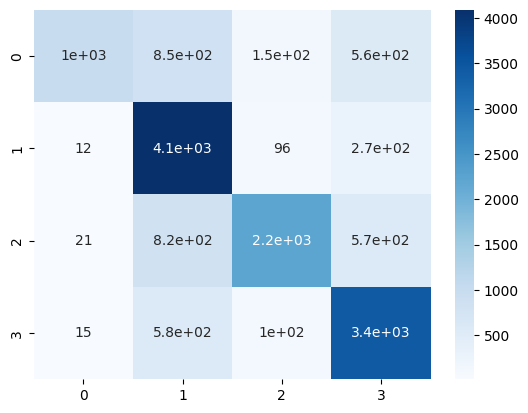

Accuracy: 0.7263513513513513


In [61]:
# Evaluating the model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_test)

# Plotting the heatmap
sns.heatmap(confusion_matrix(y_test, y_pred),
            cmap='Blues',
            annot=True)
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

### 3. Implement the Sentiment Analysis using RNN.

In [4]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, stratify=df["labels"])
train.shape, test.shape

((59196, 2), (14800, 2))

In [ ]:
from gensim.models import Word2Vec

wv = Word2Vec(sentences=corpus, vector_size=5000, window=3, min_count=1)
wv_test = Word2Vec(sentences=corpus_test, vector_size=5000, window=3, min_count=1)

# Vectorizing the training dataset
X_train = np.zeros((59196, 5000))
for idx, _ in enumerate(train["text"].values):
    words = _.split()
    X_train[idx, :] = sum([wv.wv[word] for word in words]) / (len(words) + 1)
    
# Vectorizing the testing dataset
X_test = np.zeros((14800, 5000))
for idx, _ in enumerate(test["text"].values):
    words = _.split()
    X_test[idx, :] = sum([wv_test.wv[word] for word in words]) / (len(words) + 1)

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# Defining the dataset
class SentimentDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    # Preprocessing the dataset
    def preprocess_text(self, idx):
        text = self.data[idx]
        # Encoding the label
        class_names = {"Positive":0,
                       "Negative":1,
                       "Neutral":2,
                       "Irrelevant":3}
        label = class_names[self.labels[idx]]
        return text, label
    
    def __getitem__(self, idx):
        # Getting the tokens and label
        tokens, label = self.preprocess_text(idx)
        # Converting the tokens and label to tensors
        tokens_t = torch.tensor(tokens).to(dtype=torch.float16)
        label_t = torch.zeros(4)
        label_t[label] = 1.0
        return tokens_t, label_t
    
# Defining the model
class RNNModel(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.fc1 = nn.Linear(5000, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.rnn1 = nn.RNN(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.rnn2 = nn.RNN(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(64, output_size)
        
    def forward(self, input_t):
        x = self.fc1(input_t)
        x = self.bn1(x)
        x = self.relu(x)
        x, _ = self.rnn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x, _ = self.rnn2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return self.classifier(x)
    
# Defining the hyperparameters
output_size = 4
epochs = 10

# Looking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating the dataset object
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)
# Creating the dataloader object
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, pin_memory=True)

# Initializing the model
model = RNNModel(output_size)
model = nn.DataParallel(model)
model = model.to(device)

# Initializing the optimizer and the loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Initializing the learning rate scheduler
total_batches = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1, total_steps=total_batches * epochs, final_div_factor=10.0
)

if next(model.parameters()).is_cuda:
    print("Model is running on GPU")
else:
    print("Model is running on CPU")

scaler = GradScaler()
    
# Training Loop
for epoch in range(epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for i, (text, labels) in enumerate(pbar):
        text = text.to(device)
        labels = labels.to(device)
        # Forward pass
        with autocast():
            outputs = model(text)
            loss = criterion(outputs, labels)
        
        # Backprop
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()
        
        # Freeing up memory in the GPU
        del text
        del labels
        
        # Reducing the learning rate
        scheduler.step()

        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

Since I do not have enough resources to execute this locally, I executed this on a cloud platform and the output can be seen in the following manner:

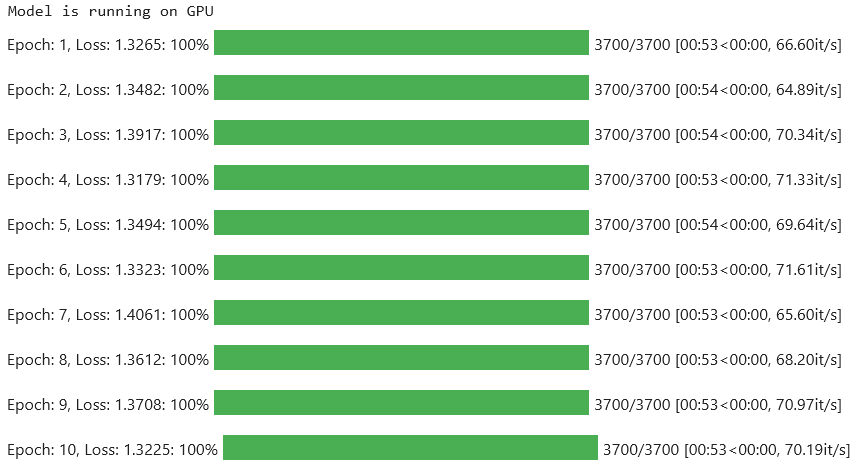

In [ ]:
# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    correct = 0
    total = 0
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            # Transferring data to GPU
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            predictions = torch.argmax(outputs, dim=1)
            # Comparing predictions with actual labels
            correct += (predictions == torch.argmax(labels, dim=1)).sum().item()
            total += labels.shape[0]
    # Calculating accuracy
    accuracy = correct / total
    pbar.set_postfix({"Test Accuracy": accuracy})
    print(f"Test Accuracy: {accuracy:.4f}")
    
evaluate(model, test_dataloader, criterion)

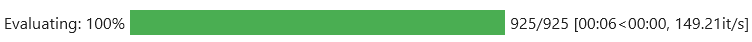

### 4. Implement the Sentiment Analysis using LSTM.

In [ ]:
# Defining the model
class LSTMModel(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.fc = nn.Linear(5000, 256)
        self.bn = nn.BatchNorm1d(256)
        self.lstm = nn.LSTM(256, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(128, output_size)
        
    def forward(self, input_t):
        x = self.fc(input_t)
        x = self.bn(x)
        x = self.relu(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        return self.classifier(x)
    
# Defining the hyperparameters
output_size = 4

# Looking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating the dataset object
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)
# Creating the dataloader object
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, pin_memory=True)

# Initializing the model
lstm_model = LSTMModel(output_size)
lstm_model = nn.DataParallel(lstm_model)
lstm_model = lstm_model.to(device)

# Initializing the optimizer and the loss function
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Initializing the learning rate scheduler
total_batches = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1, total_steps=total_batches * epochs, final_div_factor=10.0
)

if next(lstm_model.parameters()).is_cuda:
    print("Model is running on GPU")
else:
    print("Model is running on CPU")

scaler = GradScaler()
    
# Training Loop
for epoch in range(epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for i, (text, labels) in enumerate(pbar):
        text = text.to(device)
        labels = labels.to(device)
        # Forward pass
        with autocast():
            outputs = lstm_model(text)
            loss = criterion(outputs, labels)
        
        # Backprop
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()
        
        # Freeing up memory in the GPU
        del text
        del labels
        
        # Reducing the learning rate
        scheduler.step()

        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

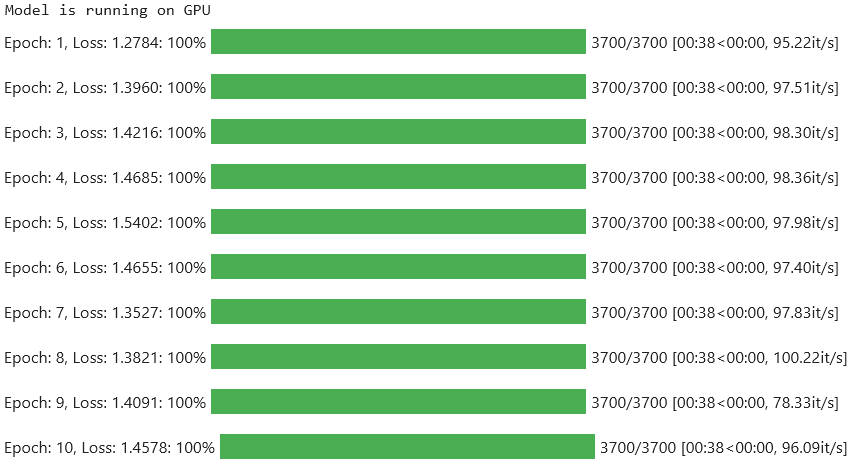

In [ ]:
# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    correct = 0
    total = 0
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            # Transferring data to GPU
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            predictions = torch.argmax(outputs, dim=1)
            # Comparing predictions with actual labels
            correct += (predictions == torch.argmax(labels, dim=1)).sum().item()
            total += labels.shape[0]
    # Calculating accuracy
    accuracy = correct / total
    pbar.set_postfix({"Test Accuracy": accuracy})
    print(f"Test Accuracy: {accuracy:.4f}")
    
evaluate(lstm_model, test_dataloader, criterion)

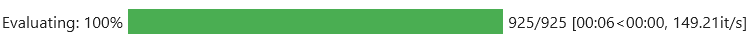

Naturally, LSTM outperforms RNN as it has better long-term dependency.

# End